<a href="https://colab.research.google.com/github/ghubnerr/andrej-karpathy-course/blob/main/makemore_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://miro.medium.com/v2/resize:fit:1400/1*EqKiy4-6tuLSoPP_kub33Q.png"/>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-12-29 16:45:39--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-12-29 16:45:39 (7.76 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
n_embd = 10
n_hidden = 200

# you don't want to set weights to exactly 0

g = torch.Generator().manual_seed(234129412)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01 # for entropy and variation

# takes away the effort to scale down the weights if they're small
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


tensor(0.0011) tensor(1.0048)
tensor(0.0005) tensor(1.0162)


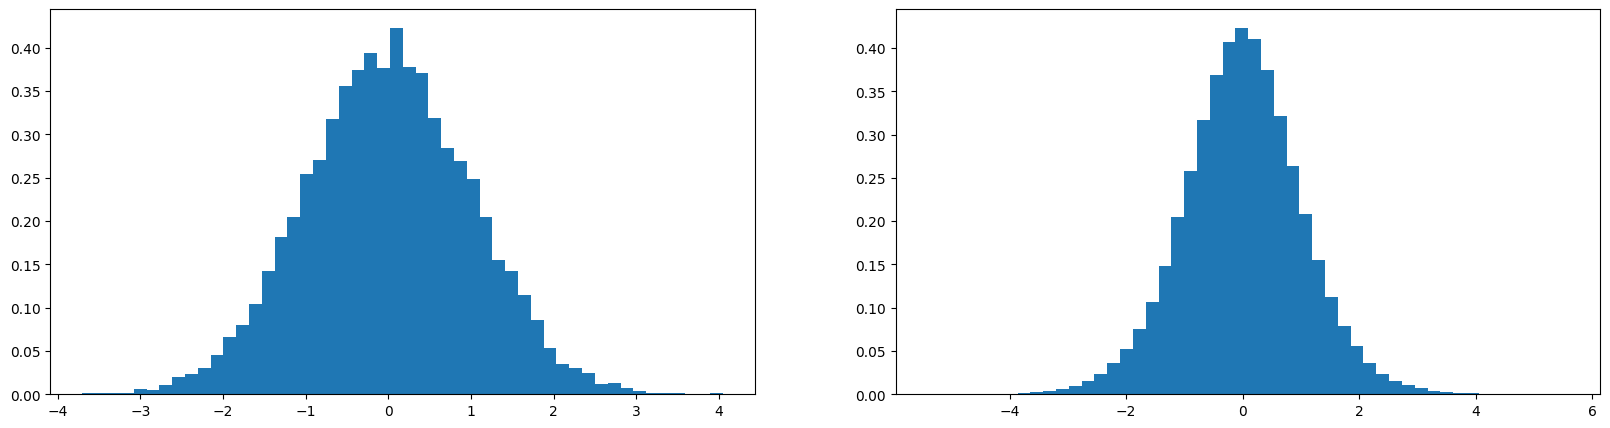

In [ ]:
# How to multiply weights by something that maintains sigma as 1

x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5 # mathematically optimal way (10=fan_in)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std()) # std_dev of 1
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In training of neural nets, you almost always have an idea of what to expect of the loss at initialization, and that depends on the loss function and the set up.

At initialization we have no reason to believe any characters to be more likely than other, which corresponds to the uniform distribution, so the probability for any character should be 1/27.0

In [ ]:
# Expected loss:
-torch.tensor(1/27.0).log()

# (Much lower than 26.)

tensor(3.2958)

The network is being initialized very confidently wrong. Here's an example:

In [ ]:
logits = torch.tensor([0, 0, 0, 0]).float() # good loss at initialization
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(probs, loss)

tensor([0.2500, 0.2500, 0.2500, 0.2500]) tensor(1.3863)


In [ ]:
# logits = torch.tensor([-3, 5, 0, -29]).float()

logits = torch.randn(4) # noraml distribution, explodes with scalars
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(probs, loss)

tensor([0.5690, 0.1918, 0.1095, 0.1297]) tensor(2.2123)


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1

  # if the output is close to 1, changing the input will not impact tanh
  # the gradient vanishes, and when it's exactly 0, it's just passed-through
  h = torch.tanh(hpreact) # element-wise tanh
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
      p.grad = None
  loss.backward()

  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
      p.data += -lr * p.grad

  if i % 10000 == 0:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


# good initial loss

      0/ 200000: 3.3113
  10000/ 200000: 2.4844
  20000/ 200000: 1.3673
  30000/ 200000: 2.3280
  40000/ 200000: 2.4695
  50000/ 200000: 2.1957
  60000/ 200000: 2.5157
  70000/ 200000: 2.2956
  80000/ 200000: 1.9318
  90000/ 200000: 1.7845
 100000/ 200000: 2.1416
 110000/ 200000: 2.0586
 120000/ 200000: 1.9933
 130000/ 200000: 2.2131
 140000/ 200000: 2.2343
 150000/ 200000: 1.7987
 160000/ 200000: 2.1304
 170000/ 200000: 2.1054
 180000/ 200000: 2.1851
 190000/ 200000: 2.0771


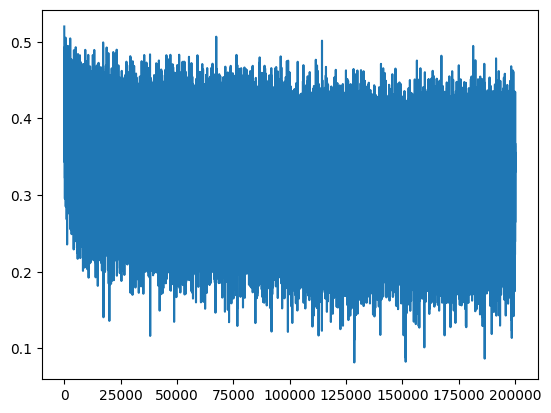

In [ ]:
# before optimizing initialization
plt.plot(lossi)

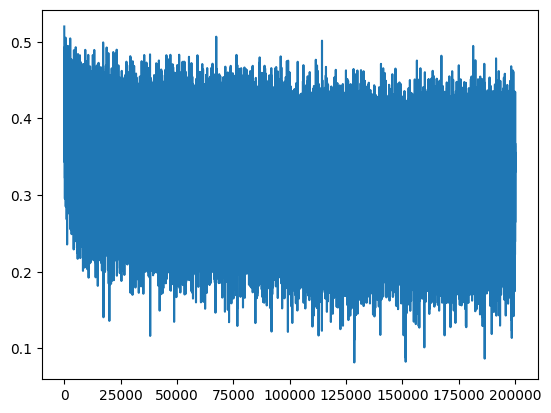

In [ ]:
# no longer a hockey stick appearance
plt.plot(lossi)

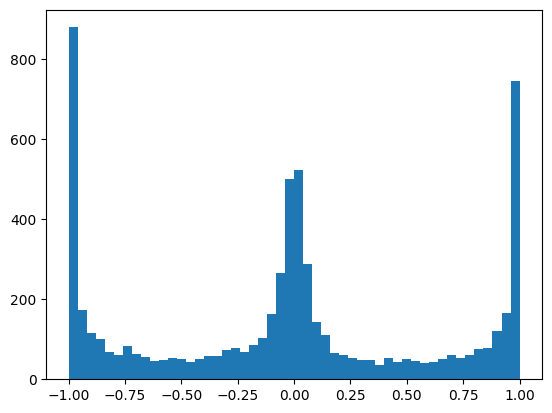

In [ ]:
plt.hist(h.view(-1).tolist(), 50);

For every tanh neurons, some gradients will indeed flow through, but you can sometimes see cases where you have dead neurons, which for this case, is a neuron that only fires 1 and -1.

The same can be true for sigmoid (since it squashes) and ReLU (since it has a flat region, zero-ing out the gradient instead of a very small number). Leaky ReLU doesn't suffer as much, ELU may.

Some neurons can be made forever dead both at initialization and optimization (through permanent "brain damage" off of the data manifold).



In our case, the neural network is really shallow, so the initialization problem is really easy to work around.

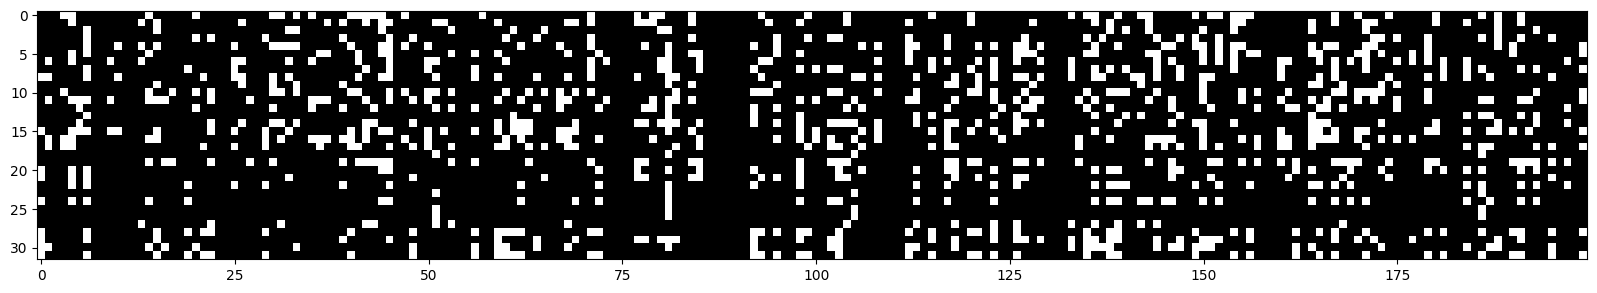

In [ ]:
# before optimization

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')


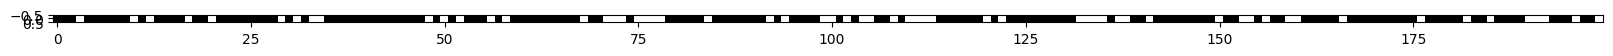

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# no saturated neurons

### The W preactivation is too large

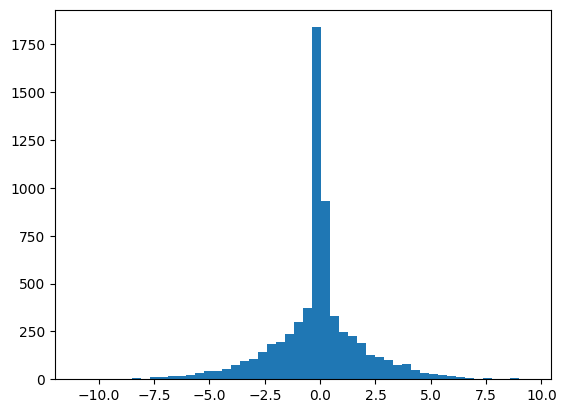

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50); # pre activation

# Kaiming Init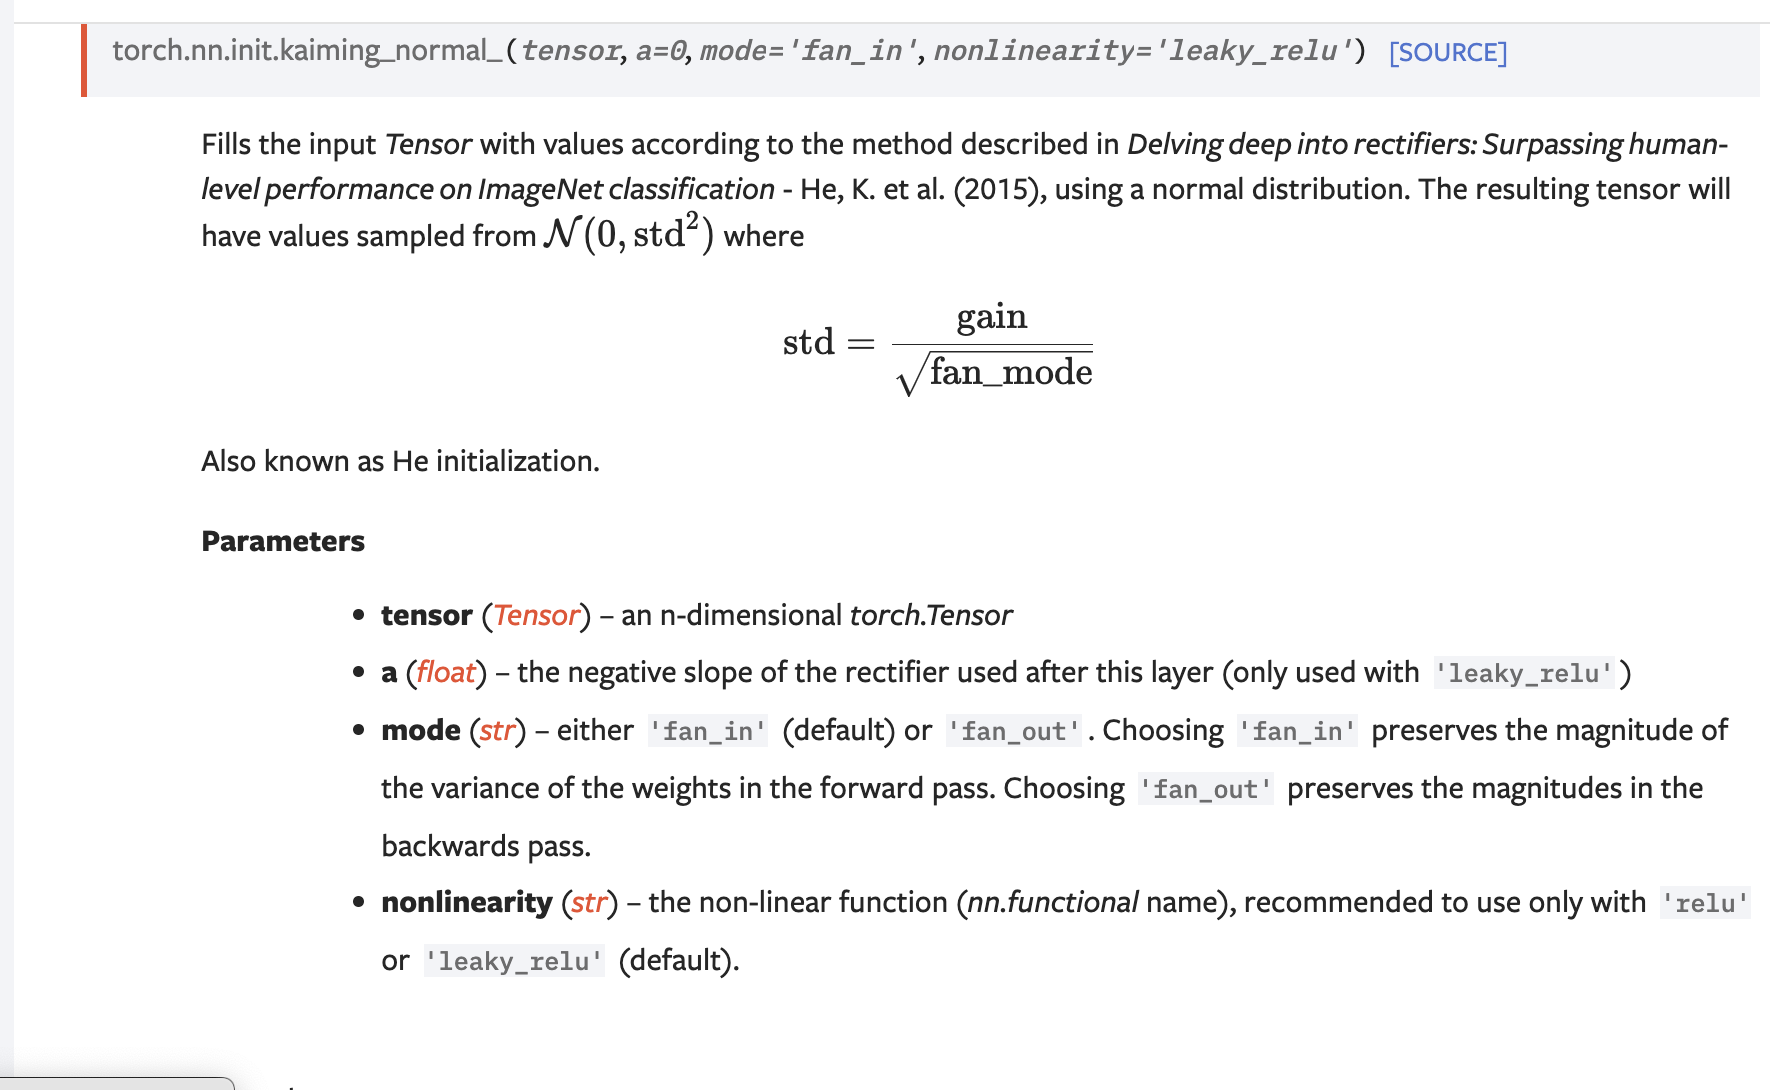

https://pytorch.org/docs/stable/nn.init.html

`torch.nn.init.kaiming_uniform_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')`

In [ ]:
# multiplying by a number n makes that number the standard deviation
(torch.randn(10000) * 0.2).std()

tensor(0.1985)

$$\text{std} = \frac{gain}{\sqrt{{\text{fan_mode}}}}$$

In [ ]:
SIGMA = (5/3) / ((n_embd * block_size)** 0.5)

In [ ]:
n_embd = 10
n_hidden = 200

# you don't want to set weights to exactly 0

g = torch.Generator().manual_seed(234129412)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * SIGMA
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1

  # if the output is close to 1, changing the input will not impact tanh
  # the gradient vanishes, and when it's exactly 0, it's just passed-through
  h = torch.tanh(hpreact) # element-wise tanh
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
      p.grad = None
  loss.backward()

  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
      p.data += -lr * p.grad

  if i % 10000 == 0:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())




      0/ 200000: 3.3164
  10000/ 200000: 2.5424
  20000/ 200000: 1.4116
  30000/ 200000: 2.4259
  40000/ 200000: 2.5015
  50000/ 200000: 2.2412
  60000/ 200000: 2.4735
  70000/ 200000: 2.2615
  80000/ 200000: 2.0160
  90000/ 200000: 1.7307
 100000/ 200000: 2.1695
 110000/ 200000: 2.1353
 120000/ 200000: 1.8825
 130000/ 200000: 2.2939
 140000/ 200000: 2.2018
 150000/ 200000: 1.8741
 160000/ 200000: 2.1191
 170000/ 200000: 2.0410
 180000/ 200000: 2.1451
 190000/ 200000: 2.0787


# Batch Normalization

Initially, we don't want to set the preactivation weights to affect the output too much, we want them to be roughly normalized. So, batch normalization literally just normalizes the hidden states (and it's also a perfectly differential operation).

In [ ]:
n_embd = 10
n_hidden = 200

# you don't want to set weights to exactly 0

g = torch.Generator().manual_seed(234129412)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * SIGMA
# b1 = torch.randn(n_hidden, generator=g) * 0.01 # -> no need for bias (bnbias)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [ ]:
hpreact.mean(0, keepdim=True).shape # over all the elements in the batch
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

$$\hat{x} ^{(k)}= \frac{x^{(k)}-E[x^{(k)}]}{\sqrt{Var[x^{(k)}}]}$$

We don't want these to be gaussian when it's not in initialization, so we want the distribution to move around, and the backprop should tell us how the distribution should move around

$$ y_i = \gamma \hat x_i + \beta$$

Scale and Shift

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/ResBlock.png">

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  # linear layer
  hpreact = embcat @ W1 # + b1
  # batch norm layer
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # non-linearity
  h = torch.tanh(hpreact) # element-wise tanh
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)
  # backward pass
  for p in parameters:
      p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
      p.data += -lr * p.grad
  # track stats
  if i % 10000 == 0:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())




      0/ 200000: 3.2947
  10000/ 200000: 2.4164
  20000/ 200000: 2.7187
  30000/ 200000: 2.3664
  40000/ 200000: 2.4351
  50000/ 200000: 1.6608
  60000/ 200000: 2.5518
  70000/ 200000: 2.3953
  80000/ 200000: 1.9366
  90000/ 200000: 2.1824
 100000/ 200000: 2.5560
 110000/ 200000: 2.1985
 120000/ 200000: 2.1917
 130000/ 200000: 1.7980
 140000/ 200000: 2.6264
 150000/ 200000: 1.9623
 160000/ 200000: 2.2942
 170000/ 200000: 2.1614
 180000/ 200000: 1.6139
 190000/ 200000: 2.0137


In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [ ]:
bnstd_running

tensor([[1.7732, 2.2097, 2.9689, 2.0483, 1.9847, 2.1687, 2.8214, 2.3980, 2.5199,
         2.0621, 1.9551, 1.6290, 2.3613, 2.1108, 2.6606, 2.2786, 2.5721, 2.4691,
         1.8243, 1.5083, 2.2104, 2.9145, 1.8162, 1.9000, 2.2033, 2.1402, 2.0067,
         1.9480, 1.8253, 2.1980, 2.2142, 2.7094, 2.3452, 2.2535, 2.5075, 2.0990,
         2.4818, 2.0428, 1.7334, 2.1810, 2.1856, 2.2813, 2.2590, 2.3253, 2.2279,
         2.1167, 2.2394, 2.2083, 2.1452, 1.9135, 2.3064, 2.0448, 2.0114, 2.3702,
         1.4992, 2.4729, 2.2989, 1.9342, 2.1175, 2.3516, 2.2982, 2.2792, 2.3810,
         2.3594, 2.1157, 2.5671, 2.2211, 2.1930, 2.3102, 2.2641, 2.0610, 2.2806,
         2.1936, 2.0257, 1.9746, 1.5373, 1.9271, 2.1931, 2.7333, 2.3359, 2.4535,
         2.0406, 2.0626, 1.3649, 2.4595, 1.9785, 2.5065, 1.8275, 2.3127, 2.0933,
         2.5277, 2.1236, 2.2658, 2.2190, 3.0380, 2.2203, 2.3112, 2.1731, 2.2697,
         2.2500, 2.0324, 1.8380, 1.9377, 2.1973, 2.3681, 2.1076, 2.2093, 2.2328,
         2.4385, 2.1008, 2.1

In [ ]:
bnstd

tensor([[1.7815, 2.2272, 3.0064, 2.0779, 2.0137, 2.1946, 2.8430, 2.4360, 2.5323,
         2.0852, 1.9745, 1.6341, 2.3925, 2.1208, 2.6845, 2.3022, 2.6130, 2.4936,
         1.8403, 1.5194, 2.2376, 2.9317, 1.8245, 1.9212, 2.2327, 2.1541, 2.0293,
         1.9701, 1.8424, 2.2140, 2.2283, 2.7426, 2.3653, 2.2888, 2.5201, 2.1103,
         2.5096, 2.0825, 1.7401, 2.2382, 2.2093, 2.3077, 2.2847, 2.3507, 2.2558,
         2.1345, 2.2733, 2.2168, 2.1605, 1.9339, 2.3472, 2.0624, 2.0333, 2.4145,
         1.5163, 2.4965, 2.3217, 1.9484, 2.1434, 2.3775, 2.3213, 2.2904, 2.4060,
         2.3907, 2.1537, 2.6057, 2.2440, 2.2199, 2.3299, 2.2858, 2.0785, 2.3079,
         2.1973, 2.0444, 2.0073, 1.5495, 1.9455, 2.2186, 2.7714, 2.3596, 2.4861,
         2.0526, 2.0898, 1.3820, 2.4772, 2.0063, 2.5237, 1.8503, 2.3258, 2.1161,
         2.5522, 2.1435, 2.2863, 2.2589, 3.0325, 2.2522, 2.3203, 2.2014, 2.2845,
         2.2797, 2.0539, 1.8600, 1.9612, 2.2182, 2.3989, 2.1238, 2.2440, 2.2554,
         2.4612, 2.1332, 2.2

In [ ]:
@torch.no_grad() # disabling gradient tracking (with torch.no_grad also works)
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  emb = C[x]
  embcat = emb.view(emb.shape[0], -1) # concat into (N, blocksize * n_embd)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.070206642150879
val 2.1160967350006104


In [ ]:
## loss log

### original:
#train 2.1245384216308594
#val   2.168196439743042

### fix softmax confidently wrong:
#train 2.07
#val   2.13

### fix tanh layer too saturated at init:
#train 2.0355966091156006
#val   2.1026785373687744

### use semi-principled "kaiming init" instead of hacky init:
#train 2.0376641750335693
#val   2.106989622116089

### add batch norm layer
#train 2.0668270587921143
#val 2.104844808578491


In [ ]:
g = torch.Generator().manual_seed(12431928041)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])] # (1, block_size, n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)

      #sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)

      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

grajtengiynnoxlangalex.
troskriquinn.
fam.
graclissabdoningtow.
graghaviongsesrynglavalgrontajaquinthine.
julwdanyolo.
fariyah.
jbrycknithaladorayishahphllenystinnwsyngxtebghb.
jakologyjuxylickixzelissiroxx.
chegaximmittobelezflevustisoyftofgannaxtadeifulnigactorlygsueghraxxu.
gregglarquiblome.
gwmyuexzakdin.
jazariussiyla.
jurtzylvonsu.
fynyliaxxdyleaxxondal.
ginshamianna.
zyarmogshritzaxxontnylyndthorgikergisablaeda.
clocxiz.
dirascioto.
julagkitlanna.


## Linear Layer
$$y = xA^T + b $$
- fan_in
- fan_out
- bias (boolean)

```
torch.nn.Linear(in_features, out_features, bia=True, device=None, dtype=None)
```

### Initialization
- The values for weights and biases are initialized from $U(-\sqrt k, \sqrt k)$, where $k=\frac{1}{\text{in_features}}$



## BatchNorm 1D
$$ y = \frac{x-E[x]}{\sqrt{Var[x] + \epsilon}} * \gamma + \beta $$

- num_features
- eps = 1e-05
- momentum = 0.1 // use slightly higher for more data
- affine = True
- track_running_stats = True
- device
- dtype


In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1D:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # paramters (trained during backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # trained during momentum update
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True, unbiased=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    if self.training:
      with torch.no_grad():
          self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
          self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
      return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(21351304123)

C = torch.randn((vocab_size, n_embd),     generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1D(n_hidden) ,Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1D(vocab_size)

]


with torch.no_grad():
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
      if isinstance(layer, Linear):
        layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

47024


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break

      0/ 200000: 3.3023


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.03%
layer 5 (      Tanh): mean -0.00, std 0.65, saturated: 2.47%
layer 8 (      Tanh): mean +0.01, std 0.65, saturated: 2.16%
layer 11 (      Tanh): mean -0.01, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean -0.00, std 0.66, saturated: 1.31%


Text(0.5, 1.0, 'activation distribution')

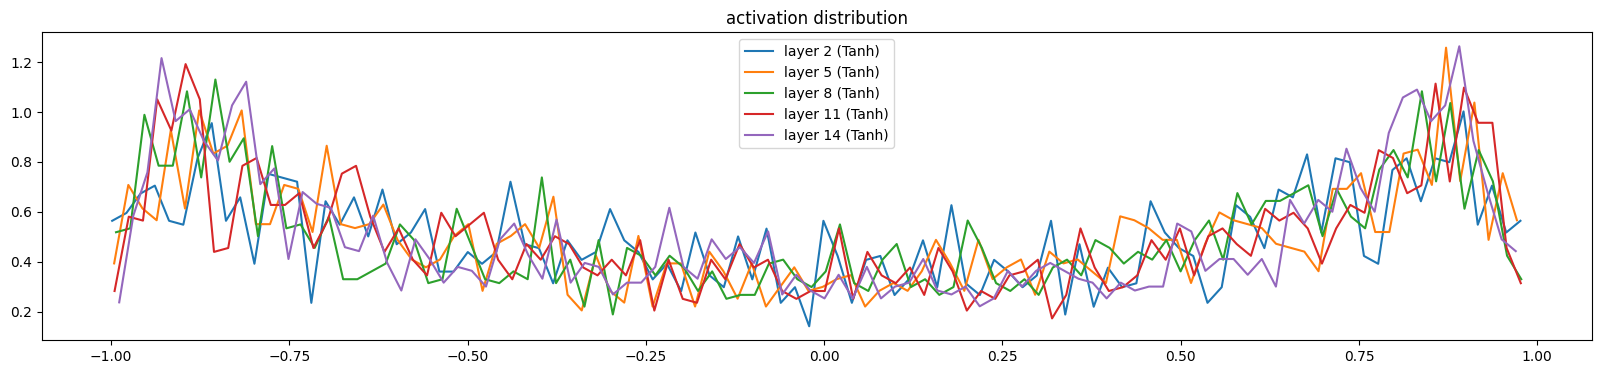

In [ ]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.785256e-03
layer 5 (      Tanh): mean +0.000000, std 2.502125e-03
layer 8 (      Tanh): mean -0.000000, std 2.354355e-03
layer 11 (      Tanh): mean -0.000000, std 2.174785e-03
layer 14 (      Tanh): mean -0.000000, std 2.277822e-03


Text(0.5, 1.0, 'gradient distribution')

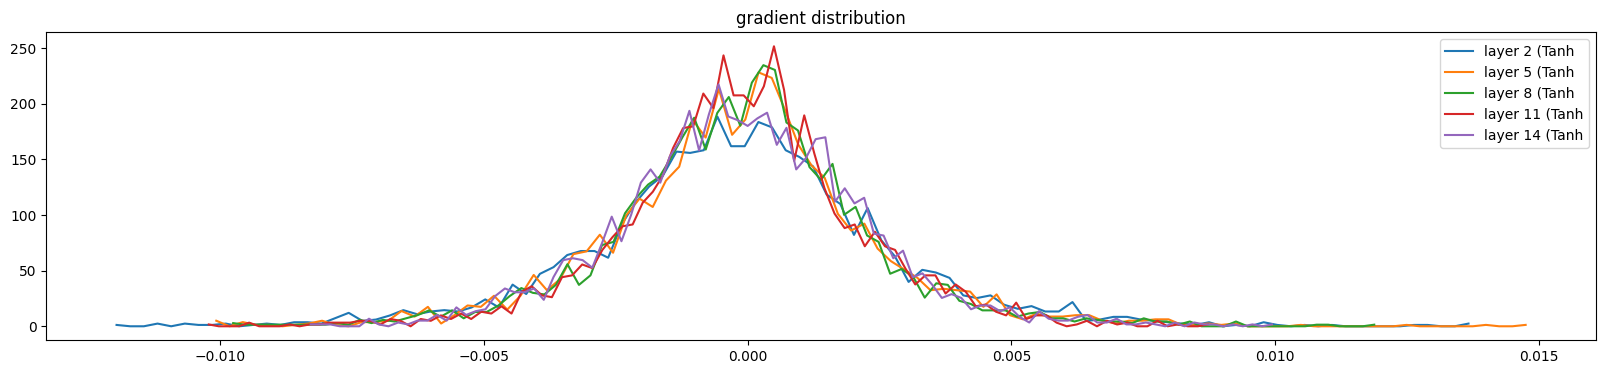

In [ ]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 7.721579e-03 | grad:data ratio 7.441097e-03
weight  (30, 100) | mean +0.000032 | std 7.232321e-03 | grad:data ratio 2.367708e-02
weight (100, 100) | mean -0.000006 | std 5.667708e-03 | grad:data ratio 3.364750e-02
weight (100, 100) | mean +0.000013 | std 5.092944e-03 | grad:data ratio 3.034280e-02
weight (100, 100) | mean -0.000019 | std 4.618824e-03 | grad:data ratio 2.740907e-02
weight (100, 100) | mean -0.000014 | std 4.150032e-03 | grad:data ratio 2.506835e-02
weight  (100, 27) | mean -0.000208 | std 8.197647e-03 | grad:data ratio 4.817767e-02


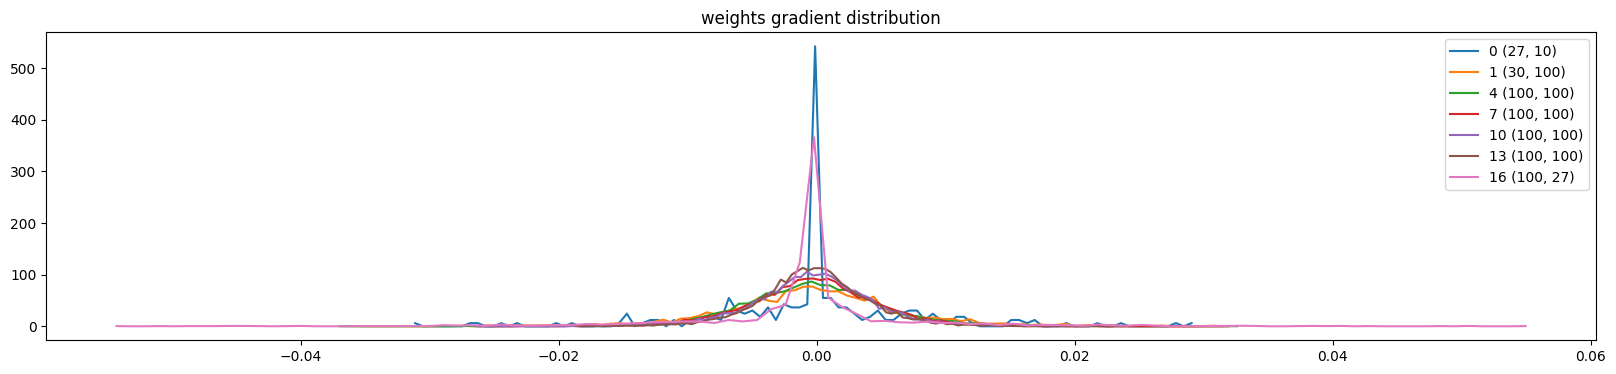

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

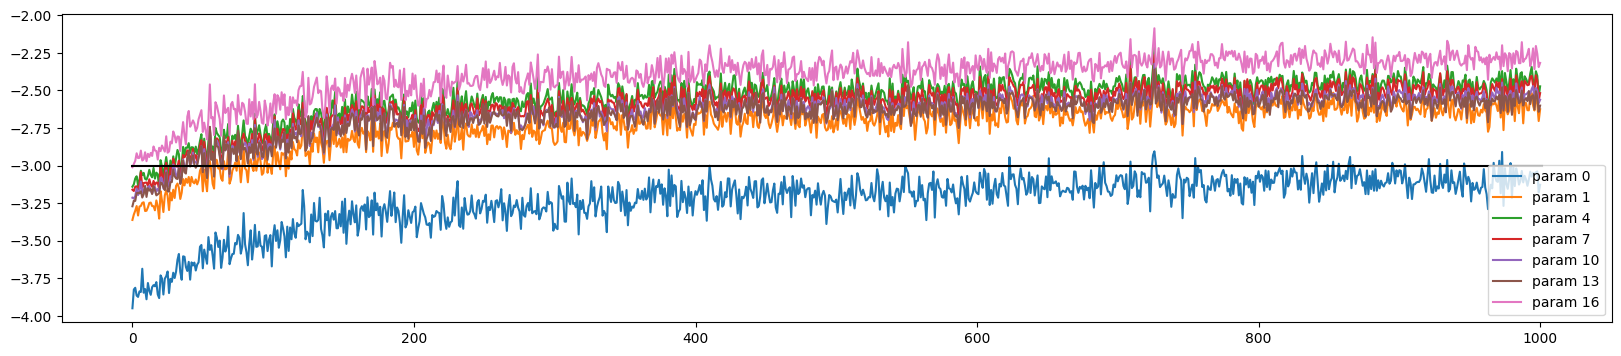

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.429020881652832
val 2.4289913177490234
